In [1]:
%config Completer.use_jedi = False
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 44.04 Milhões de habitantes em SP
SP_POP = 44.04e6

In [2]:
data = pd.read_csv("../data/vacinados_clean.csv", parse_dates=["Data"])
data.head()

,Data,Vacinados,Delta
0,2021-01-19 11:16:00,3908,NaN
1,2021-01-20 14:14:00,17318,13410.0
2,2021-01-20 15:11:00,18409,1091.0
3,2021-01-20 15:19:00,18729,320.0
4,2021-01-20 15:24:00,18834,105.0


In [3]:
# Eliminando nulos e valores onde a diferença do anterior é menor que 0
# por que as vezes o site do vacinometro reporta valores errados
data = data.dropna()
data = data.drop(data.query("Delta <= 0").index)
data.sample(10)

,Data,Vacinados,Delta
566,2021-01-24 20:55:00,130759,13.0
459,2021-01-24 06:00:00,124665,3.0
215,2021-01-22 13:13:00,75482,374.0
217,2021-01-22 13:27:00,75857,253.0
471,2021-01-24 07:30:00,124756,32.0
205,2021-01-22 10:25:00,63331,774.0
654,2021-01-25 10:40:00,137800,260.0
268,2021-01-23 07:35:00,108010,72.0
594,2021-01-25 01:30:00,130964,2.0
81,2021-01-21 03:37:00,22782,2.0


In [4]:
# Vamos remover todas as entradas cuja a diferença
# da anterior (coluna delta) estiver acima de 3 desvios padrões da média (pelo mesmo motivo)
std = data.Delta.std()
mean = data.Delta.mean()
data = data.drop(data.query("Delta > @mean+2.5*@std").index)

In [5]:
# Para cada entrada, calcula em qual hora do ano ela foi computada (24*(dia_do_ano-1) + hora_do_dia)
# Dia do ano - 1 por que o primeiro dia começa na hora 0
data["HourOfYear"] = 24*(data.Data.dt.dayofyear-1) + data.Data.dt.hour
# Agrupa registros q aconteceram dentro da mesma hora e escolhe o maior valor
vacinados_hora = data.groupby("HourOfYear").max()["Vacinados"]

x, y = vacinados_hora.index, vacinados_hora
print(len(x), len(y))

99 99


In [6]:
# conjuntos de treino e teste
train, test = y[:70], y[70:]

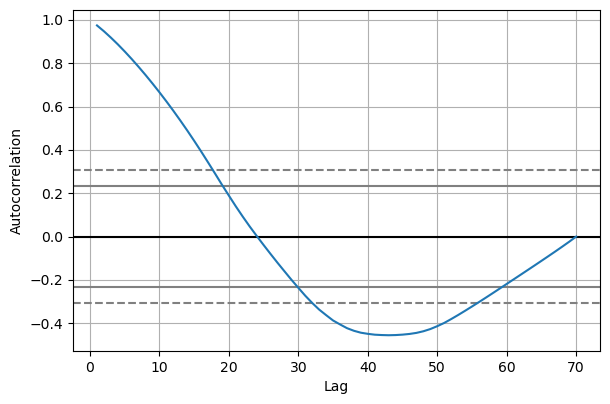

In [7]:
# Autocorrelação do conjunto de treino
fig,ax = plt.subplots(figsize=(6,4), dpi=100)
fig.tight_layout()
autocorrelation_plot(train, ax);

/home/phyrlae/miniconda3/envs/vacinometro/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/phyrlae/miniconda3/envs/vacinometro/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/phyrlae/miniconda3/envs/vacinometro/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


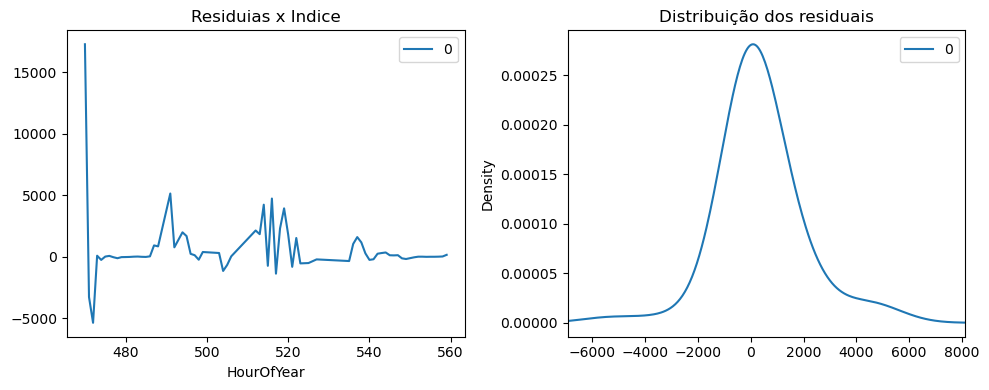

                  0
count     70.000000
mean     596.811129
std     2513.717900
min    -5367.397327
25%     -111.802028
50%       25.532079
75%      678.184095
max    17296.246108


In [31]:
# Ajustandoum modelo arima (5,1,0) com parametro de tendencia c
model = ARIMA(train, order=(5,1,0), trend='c')
model_fit = model.fit()
residuals = pd.DataFrame(model_fit.resid)

r_mean = residuals[0].mean()
r_std = residuals[0].std()
# Gŕagicos dos residuais

fig, ax = plt.subplots(ncols=2, figsize=(10,4), dpi=100)
ax[0].set(title="Residuias x Indice")
ax[1].set(title="Distribuição dos residuais",
         xlim=(r_mean-3*r_std, r_mean+3*r_std))
residuals.plot(ax=ax[0])
residuals.plot(kind='kde', ax=ax[1])
fig.tight_layout()
plt.show()
print(residuals.describe())

In [9]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Vacinados   No. Observations:                   70
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -603.517
Date:                Mon, 25 Jan 2021   AIC                           1221.034
Time:                        19:06:32   BIC                           1236.672
Sample:                             0   HQIC                          1227.238
                                 - 70                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         21.7539   3073.432      0.007      0.994   -6002.063    6045.571
ar.L1          0.2471      0.063      3.898      0.000       0.123       0.371
ar.L2          0.4662      0.117      3.970      0.000       0.236       0.696
ar.L3         -0.0390      0.136     -0.286      0.775      -0.306       0.228
ar.L4          0.0261      0.165      0.158      0.874      -0.297       0.349
ar.L5         -0.0258      0.164     -0.158      0.875      -0.347       0.295
sigma2      1.935e+06    2.7e+05      7.167      0.000    1.41e+06    2.46e+06
===================================================================================
Ljung-Box (L1) (Q):                   3.24   Jarque-Bera (JB):                62.62
Prob(Q):                              0.07   Prob(JB):                         0.00
Heteroskedasticity (H):               0.06   Skew:                             0.51
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [10]:
"""
Faz um rolling forecast do model, adicionando um datapoint e fazendo o refit
antes de cada previsão
"""
def rolling_forecast(history, steps, model_params):
    history = history
    predictions = []
    for t in range(steps):
        model = ARIMA(history, **model_params)
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test.iloc[t]
        history.append(obs)
    return predictions

In [11]:
"""
Faz o grid search para otimizar o modelo
"""
def arima_grid_search(train, test, grid, score=mean_squared_error):
    best_score = None
    best_params = None
    best_pred = None
    
    for params in grid:
        print(params)
        predictions = rolling_forecast(list(train), len(test), params)
        model_score = score(test, predictions)
        if best_score is None or model_score < best_score:
            best_params, best_score, best_pred= params, model_score, predictions
    
    return best_params, best_score, predictions

In [22]:
grid = [
    {'order': (5,1,0), 'trend': 'c'},
    {'order': (10,1,0), 'trend': 'c'},
    {'order': (15,1,0), 'trend': 'c'},
    {'order': (20,1,0), 'trend': 'c'}
]

best_params, best_score, predictions = arima_grid_search(train, test, grid)

{'order': (5, 1, 0), 'trend': 'c'}
{'order': (10, 1, 0), 'trend': 'c'}
{'order': (15, 1, 0), 'trend': 'c'}
{'order': (20, 1, 0), 'trend': 'c'}


In [23]:
best_params, best_score**(1/2)

({'order': (20, 1, 0), 'trend': 'c'}, 578.5260367972655)

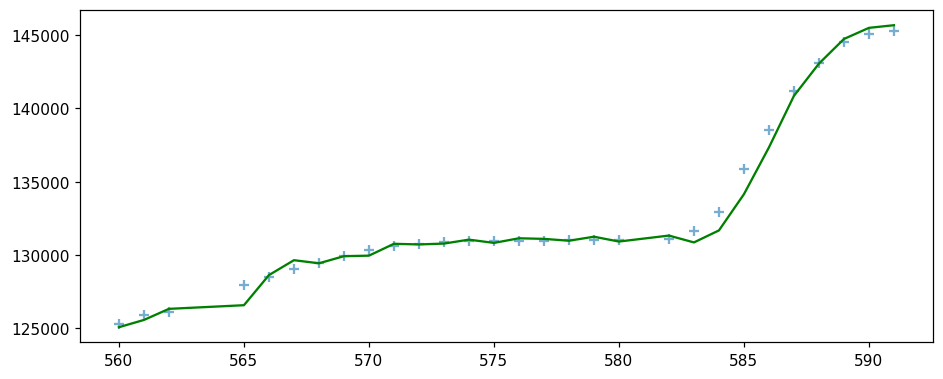

In [24]:
fig, ax = plt.subplots(figsize = (10,4), dpi=110, sharey=True)

ax.scatter(test.index, test, alpha=0.6, marker='+')
ax.plot(test.index,predictions, color='green');

In [ ]:
mean_squared_error(test, predictions)**(1/2)